# **Anti-Spam Software for a University**

ProfessionAI, a company specializing in AI-based automation, wants to develop a software library capable of analyzing and classifying incoming emails. The primary objective is to identify SPAM emails and subsequently conduct in-depth content analysis.

The CEO expressed the need to focus on SPAM emails to better understand associated trends, content, and behaviors. This information will be used to improve the security of corporate communications and refine spam filters.

*Project Objectives*

The CTO provided an email dataset to perform the following tasks:

1. Add a classifier to identify SPAM emails.
2. Identify the main topics among emails classified as SPAM.
3. Calculate the semantic distance between the obtained topics to assess the heterogeneity of SPAM email content.
4. Extract information about the organizations mentioned from NON-SPAM emails.

### **Initial exploratory analysis**

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=0f27654f001d6ec4f9d25962efd3c56cbb83fb5a20120510287fe3bb16685219
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from langdetect import detect, DetectorFactory, lang_detect_exception

# statistics
from scipy.spatial.distance import jensenshannon

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report

RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# import the dataset
df = pd.read_csv('spam_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
df.shape

(5171, 4)

The dataset consists of 5171 rows and 4 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
null = df.isnull().sum()
print(f"Null values:\n{null}")

Null values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


In [ ]:
df = df.drop('Unnamed: 0', axis=1) # drop the Unnamed:0 column

In [ ]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


lang_detect_exception.LangDetectException is used to prevent code from crashing when detect() fails to identify the language of a text (for example, because it's empty, too short, or contains only symbols). By handling the exception, I return "unknown" instead of throwing an error, so the process continues uninterrupted.

In [ ]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except (lang_detect_exception.LangDetectException, TypeError):
        return "unknown"

df['language'] = df['text'].apply(detect_language)

# count and report discarded emails
unknown_count = sum(df['language'] == 'unknown')
print(f'Emails discarded due to undetected language: {unknown_count}')

# filter only emails in English
df = df[df['language'] == 'en'].copy()

df.drop(columns=['language'], inplace=True)

Emails discarded due to undetected language: 0


In [ ]:
df.shape

(5075, 3)

observations dropped from 5171 to 5075

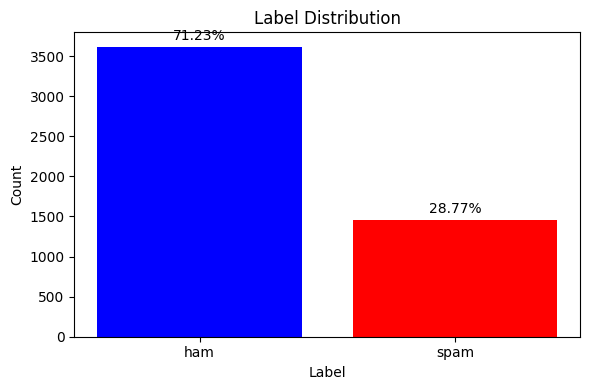

In [ ]:
count = Counter(df["label"])
total = len(df["label"])

color_map = {"spam": "red", "ham": "blue"}
order = ["ham", "spam"]

count = {label: count[label] for label in order if label in count}
colors = [color_map.get(label, "gray") for label in count.keys()]

plt.figure(figsize=(6, 4))
bars = plt.bar(count.keys(), count.values(), color=colors)

# adds the percentage of the total above each bar
for bar, (label, value) in zip(bars, count.items()):
    percentuale = (value / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01, f"{percentuale:.2f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The dataset shows a prevalence of ham (71.23%) compared to spam ones (28.77%)

In [ ]:
df['text_length'] = df['text'].apply(len)
df.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,3615.0,972.497925,1367.117464,17.0,236.50,528.0,1225.50,31860.0
spam,1460.0,1218.182192,1812.258382,10.0,289.25,571.5,1255.25,21749.0


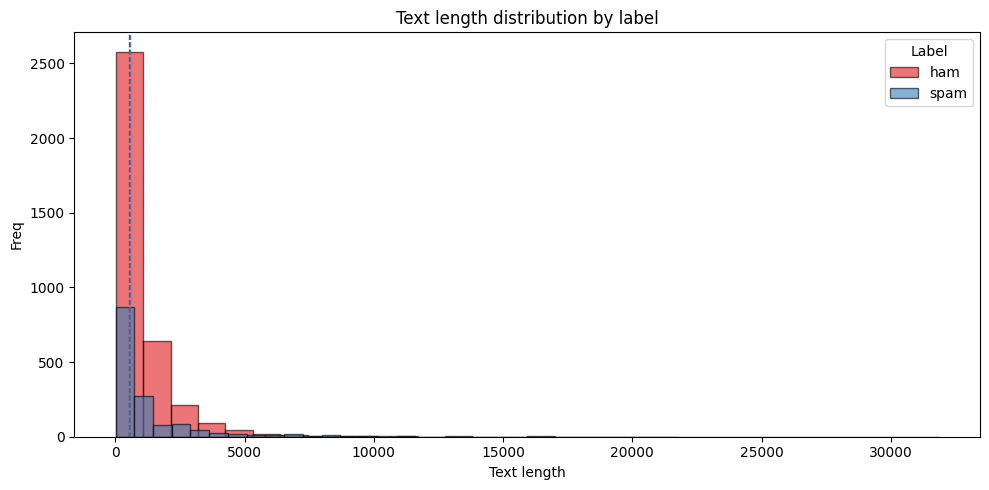

In [ ]:
plt.figure(figsize=(10, 5))
colors = plt.cm.Set1.colors

for i, (label, group) in enumerate(df.groupby('label')):
    plt.hist(group['text_length'],
             bins=30,
             alpha=0.6,
             label=str(label),
             color=colors[i % len(colors)],
             edgecolor='black')
    # show the median
    median = group['text_length'].median()
    plt.axvline(median, color=colors[i % len(colors)], linestyle='dashed', linewidth=1)

plt.xlabel('Text length')
plt.ylabel('Freq')
plt.title('Text length distribution by label')
plt.legend(title="Label")
plt.tight_layout()
plt.show()

Both distributions are strongly skewed to the left, with most texts being quite short.
The vertical dashed line indicates the average text length for each category.

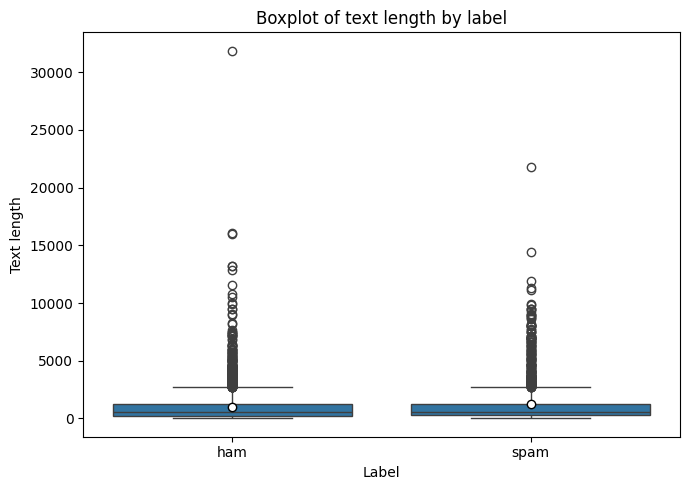

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x='label', y='text_length', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
plt.title('Boxplot of text length by label')
plt.xlabel('Label')
plt.ylabel('Text length')
plt.tight_layout()
plt.show()

The length of the texts varies greatly in both groups, but spam messages tend to have slightly longer texts and more variability.

### **Preprocessing**

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

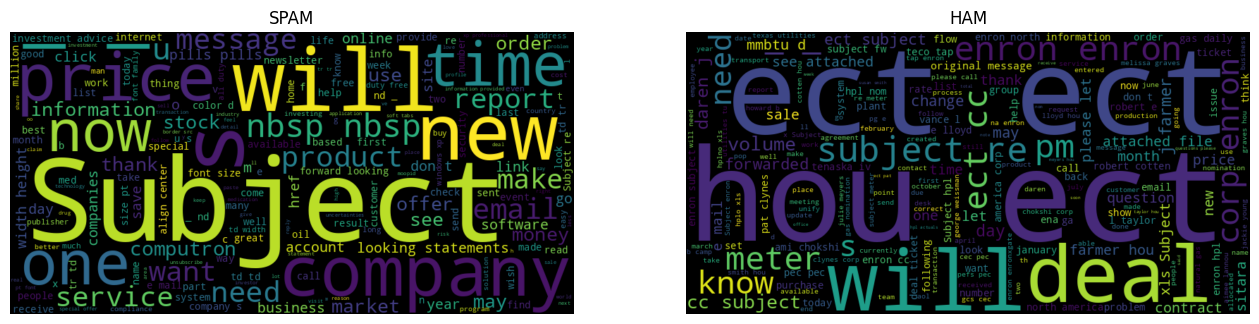

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Spam
wordcloud_spam = WordCloud(width=800, height=400).generate(' '.join(df[df['label']=='spam']['text']))
axs[0].imshow(wordcloud_spam, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("SPAM")

# Ham
wordcloud_ham = WordCloud(width=800, height=400).generate(' '.join(df[df['label']=='ham']['text']))
axs[1].imshow(wordcloud_ham, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("HAM")

plt.show()

Spam and ham use different vocabularies.
- In SPAM, you immediately see words like offer, free, now, company, and pills.
- In HAM, the words are completely different: enron, hou, pm, corp.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+|[\w\.-]+@[\w\.-]+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lemmatizes and removes stopwords and short words
    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if (
            token.lemma_ not in stop_words and    # remove stopword
            token.is_alpha and                    # only real words
            len(token) > 2                        # avoid short words/noise
        )
    ]
    # recreate the clean string
    return ' '.join(lemmas)

### *Spam/ham classification*

In [ ]:
X = df['text'].apply(clean_text)
y = df['label']

In [ ]:
vectorizer = CountVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vec , y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [ ]:
lr = LogisticRegression(random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       723
        spam       0.93      0.99      0.96       292

    accuracy                           0.98      1015
   macro avg       0.96      0.98      0.97      1015
weighted avg       0.98      0.98      0.98      1015



- For ham (non-spam), the model is very precise (precision 0.99), meaning almost all emails classified as ham are indeed ham, and it finds almost all of them (recall 0.97).

- For spam, the precision is slightly lower (0.93), but the model misses virtually no spam (recall 0.99), so it identifies almost all of them.

Overall, the model has an accuracy of 98%

### *Identify the main topics among emails classified as SPAM.*

In [ ]:
# pre-filter only SPAM emails
spam_text = df[df['label'] == 'spam']['text'].apply(clean_text)

In [ ]:
cv = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
dtm = cv.fit_transform(spam_text)

In [ ]:
# topic modelling (LDA)
lda = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
def print_topics(model, feature_names, n_top_words=10):

    for topic_idx, topic in enumerate(model.components_):
        top_features_inds = topic.argsort()[:-n_top_words - 1:-1]  # gets the indexes of the most relevant words
        top_features = [feature_names[i] for i in top_features_inds]  # retrieve word names
        top_scores = [topic[i] for i in top_features_inds] # retrieve word weights

        print(f"Topic {topic_idx}: {', '.join(top_features)}")
        print(f"  Weight: {np.round(top_scores, 2)}")

In [ ]:
print_topics(lda, cv.get_feature_names_out())

Topic 0: company, statement, stock, information, security, investment, report, price, look, make
  Weight: [897.77 497.2  431.37 364.52 332.19 312.28 299.37 253.39 235.47 212.2 ]
Topic 1: pill, good, online, account, money, make, need, http, know, price
  Weight: [336.82 219.52 195.41 191.99 186.91 149.81 148.66 146.79 146.68 144.23]
Topic 2: com, price, computron, message, www, contact, microsoft, remove, email, software
  Weight: [406.97 298.02 242.2  240.49 240.28 205.5  203.9  200.18 188.26 178.65]
Topic 3: number, claim, international, prize, darial, program, email, category, note, lottery
  Weight: [66.88 64.58 55.35 51.71 50.19 45.42 41.49 37.15 37.08 36.12]
Topic 4: http, font, nbsp, height, com, width, www, size, align, border
  Weight: [676.29 512.82 418.2  363.2  360.78 306.2  283.72 263.85 233.19 194.97]


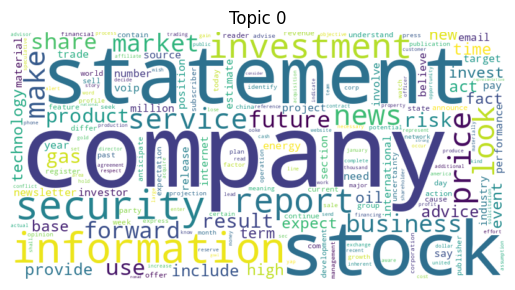

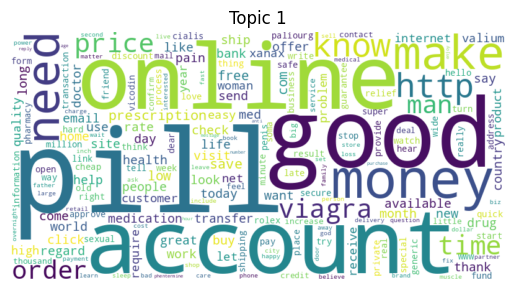

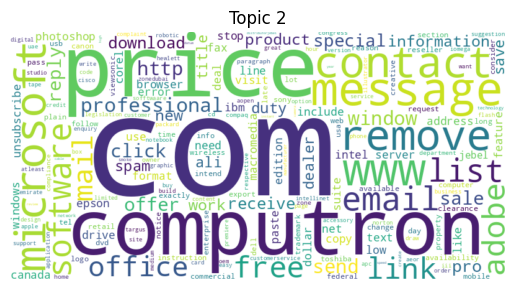

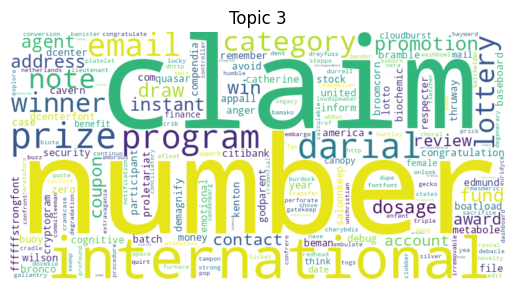

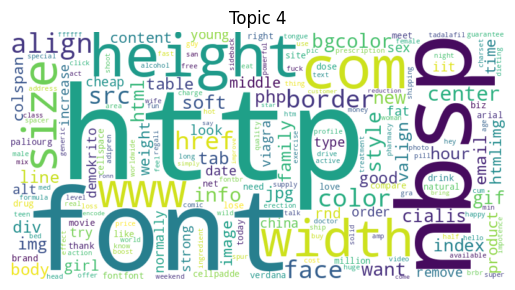

In [ ]:
# wordcloud
for i, topic in enumerate(lda.components_):
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(dict(zip(cv.get_feature_names_out(), topic)))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i}")
    plt.show()

### *Calculate the semantic distance between the obtained topics to evaluate the heterogeneity of the contents of SPAM emails.*

To calculate the semantic distance between the identified topics, the Jensen-Shannon distance, a metric that measures the similarity between probability distributions, was used.

In [ ]:
# topic normalization
normalized_topics = np.array([topic / np.sum(topic) for topic in lda.components_])

In [ ]:
# js distance calculation
def topic_distances(normalized_topics):
    n_topics = len(normalized_topics)
    dists = np.zeros((n_topics, n_topics))
    for i in range(n_topics):
        for j in range(i+1, n_topics):
            dist = jensenshannon(normalized_topics[i], normalized_topics[j])
            dists[i, j] = dist
            dists[j, i] = dist
    return dists

In [ ]:
distances = topic_distances(normalized_topics)

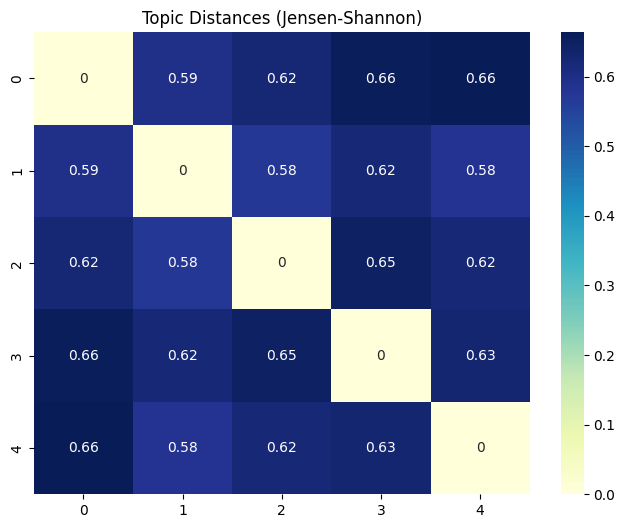

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(distances, annot=True, cmap='YlGnBu')
plt.title('Topic Distances (Jensen-Shannon)')
plt.show()

In [ ]:
print("Diversity score media:", np.mean(distances[np.triu_indices(5, k=1)]))

Diversity score media: 0.6219194389475011


### *Extract information about the organizations mentioned from NON-SPAM emails.*

In [ ]:
# extract organizations from text
def extract_org(text):
  doc=nlp(text)
  return [ent.text for ent in doc.ents if ent.label_ == 'ORG']

In [ ]:
# select ham email texts
ham_text = df[df['label'] == 'ham']['text']

In [ ]:
def is_real_org(name):
    name = name.strip().lower()
    # excludes anything that is too short, only symbols, or contains typical file extensions
    if len(name) < 3: return False
    if name in {'doc', 'xls', '?'}: return False
    if any(ext in name for ext in ['.csv', '.xls', '.doc', '.jpg', '.txt']): return False
    if re.match(r".+\/.+\/", name): return False
    return True

In [ ]:
org_list = ham_text.apply(extract_org)

In [ ]:
all_orgs = [org for orgs in org_list for org in orgs]
filtered_orgs = [org for org in all_orgs if is_real_org(org)]
org_counts = Counter(filtered_orgs)

In [ ]:
print("Top 10 Organizations in Ham Emails:")
for org, count in org_counts.most_common(10):
    print(f"{org}: {count}")

Top 10 Organizations in Ham Emails:
north america corp .: 166
enron north america corp .: 81
pg & e: 71
exxon: 52
enron corp .: 51
boas / hou: 45
coastal oil & gas corporation
: 43
lamadrid / hou: 42
capital & trade resources corp .: 39
texaco: 38


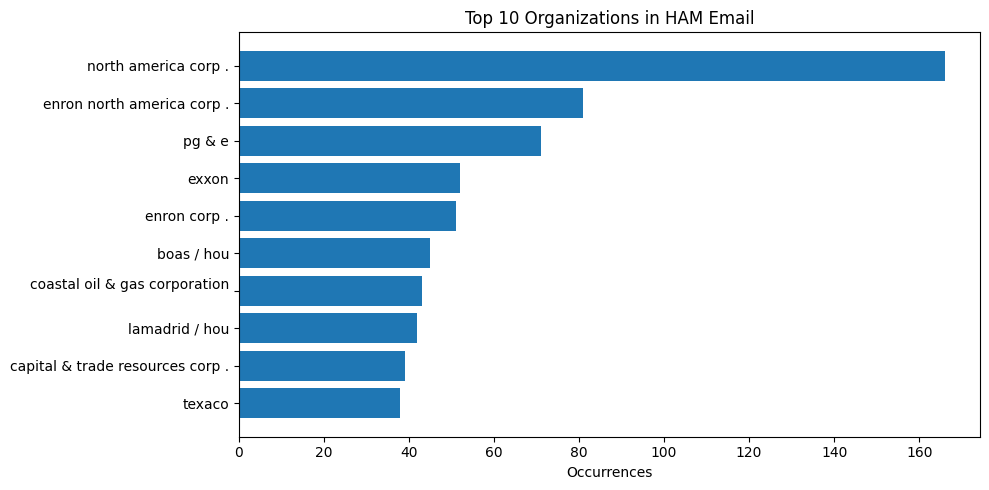

In [ ]:
top_orgs = org_counts.most_common(10)
org_names, org_vals = zip(*top_orgs)
plt.figure(figsize=(10, 5))
plt.barh(org_names[::-1], org_vals[::-1])
plt.xlabel('Occurrences')
plt.title('Top 10 Organizations in HAM Email')
plt.tight_layout()
plt.show()

Entity extraction identified the most frequently mentioned organizations in ham emails.

- North America Corp is the most frequently mentioned organization with approximately 166 occurrences.

- Enron North America Corp (approximately 81 occurrences) and PG&E (approximately 71 occurrences) follow.


### Conclusion

This project developed a comprehensive solution for the automatic analysis of university emails, with a focus on detecting and understanding SPAM.
The classification model, based on logistic regression and advanced preprocessing, demonstrated high precision and recall, ensuring accurate distinction between SPAM and HAM messages.

Thematic analysis using topic modeling (LDA) allowed us to identify the main topics covered in SPAM emails, highlighting content diversity by studying the semantic distances between the identified topics.
These results not only improve the effectiveness of the spam filter but also identify new trends and techniques used by spammers.

Finally, extracting the organizations mentioned in HAM emails provides a useful overview of the companies and institutions most involved in regular university communications, also enabling us to identify potential risks or partnership opportunities.